In [ ]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import pickle

In [ ]:
#Consolidação dos arquivos de dados dos invesores
input_file_path = "./"
output_file_path = "./"
excel_file_list = os.listdir(input_file_path)
excel_file_list
Dados_Inversores = pd.DataFrame()

Cabecalho = ['Time','InverterSN','Data LoggerSN','Alert Details','Alert Code','DC Voltage PV1(V)','DC Voltage PV2(V)',
             'DC Voltage PV3(V)','DC Voltage PV4(V)','DC Current1(A)','DC Current2(A)','DC Current3(A)','DC Current4(A)',
             'Total DC Input Power(W)','AC Voltage R/U/A(V)','AC Voltage S/V/B(V)','AC Voltage T/W/C(V)','AC Current R/U/A(A)',
             'AC Current S/V/B(A)','AC Current T/W/C(A)','AC Output Total Power (Active)(W)','AC Output Frequency R(Hz)','Generation of Last Month (Active)(kWh)',
             'Daily Generation (Active)(kWh)','Total Generation (Active)(kWh)','Power Grid Total Apparent Power(VA)','Grid Power Factor','Inverter Temperature(℃)',
             'Inverter Status','Generation Yesterday(kWh)','System Time']

for excel_files in excel_file_list:
 if excel_files.endswith(".xlsx"):
  df1 = pd.read_excel(input_file_path+excel_files).iloc[3:] #ignorando o cabeçalho presente em todos os arquivos
  if excel_files.startswith("inversor1"): #arquivos do inversor 1 possuem menos colunas que os do inversor 2
    df1.insert(7,'DC Voltage PV3(V)',0)
    df1.insert(8,'DC Voltage PV4(V)',0)
    df1.insert(11,'DC Current3(A)',0)
    df1.insert(12,'DC Current4(A)',0)

  df1.columns = Cabecalho
  Dados_Inversores = Dados_Inversores.append(df1, ignore_index=True)





#Dados_Inversores.to_excel(output_file_path+"Dados_Inversores.xlsx") #usado para verificar os dados

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
#Formatando os tipos de dados
import datetime as dt

Dados_Inversores[['DC Voltage PV1(V)','DC Voltage PV2(V)',
             'DC Voltage PV3(V)','DC Voltage PV4(V)','DC Current1(A)','DC Current2(A)','DC Current3(A)','DC Current4(A)',
             'Total DC Input Power(W)','AC Voltage R/U/A(V)','AC Voltage S/V/B(V)','AC Voltage T/W/C(V)','AC Current R/U/A(A)',
             'AC Current S/V/B(A)','AC Current T/W/C(A)','AC Output Total Power (Active)(W)','AC Output Frequency R(Hz)','Generation of Last Month (Active)(kWh)',
             'Daily Generation (Active)(kWh)','Total Generation (Active)(kWh)','Power Grid Total Apparent Power(VA)','Grid Power Factor','Inverter Temperature(℃)','Generation Yesterday(kWh)']] = Dados_Inversores[['DC Voltage PV1(V)','DC Voltage PV2(V)',
             'DC Voltage PV3(V)','DC Voltage PV4(V)','DC Current1(A)','DC Current2(A)','DC Current3(A)','DC Current4(A)',
             'Total DC Input Power(W)','AC Voltage R/U/A(V)','AC Voltage S/V/B(V)','AC Voltage T/W/C(V)','AC Current R/U/A(A)',
             'AC Current S/V/B(A)','AC Current T/W/C(A)','AC Output Total Power (Active)(W)','AC Output Frequency R(Hz)','Generation of Last Month (Active)(kWh)',
             'Daily Generation (Active)(kWh)','Total Generation (Active)(kWh)','Power Grid Total Apparent Power(VA)','Grid Power Factor','Inverter Temperature(℃)','Generation Yesterday(kWh)']].apply(pd.to_numeric)

Dados_Inversores[['Time','System Time']] = Dados_Inversores[['Time','System Time']].apply(pd.to_datetime)
Dados_Inversores['Horario'] = pd.to_datetime(Dados_Inversores['Time']).dt.time
Dados_Inversores['Horario Ordinal'] = ((Dados_Inversores['Time'].dt.hour*3600)+(Dados_Inversores['Time'].dt.minute*60)+(Dados_Inversores['Time'].dt.second)) #transformando o horário de cada período em um valor int, para que ele possa ser interpretado pelo algoritmo de trino Random Forest Regression
print(Dados_Inversores.dtypes)
Dados_Inversores
#Dados_Inversores.to_excel(output_file_path+"Dados_Inversores.xlsx") #usado para verificar os dados

Time                                      datetime64[ns]
InverterSN                                        object
Data LoggerSN                                     object
Alert Details                                     object
Alert Code                                        object
DC Voltage PV1(V)                                float64
DC Voltage PV2(V)                                float64
DC Voltage PV3(V)                                float64
DC Voltage PV4(V)                                float64
DC Current1(A)                                   float64
DC Current2(A)                                   float64
DC Current3(A)                                   float64
DC Current4(A)                                   float64
Total DC Input Power(W)                            int64
AC Voltage R/U/A(V)                              float64
AC Voltage S/V/B(V)                              float64
AC Voltage T/W/C(V)                              float64
AC Current R/U/A(A)            

,Time,InverterSN,Data LoggerSN,Alert Details,Alert Code,DC Voltage PV1(V),DC Voltage PV2(V),DC Voltage PV3(V),DC Voltage PV4(V),DC Current1(A),...,Daily Generation (Active)(kWh),Total Generation (Active)(kWh),Power Grid Total Apparent Power(VA),Grid Power Factor,Inverter Temperature(℃),Inverter Status,Generation Yesterday(kWh),System Time,Horario,Horario Ordinal
0,2022-06-20 06:56:14,1104F0191290005,4006102660,NaN,NaN,200.0,199.9,0.0,0.0,0.1,...,0.0,36532.0,30,1.0,17.4,1022,30.1,2020-06-22 07:04:16,06:56:14,24974
1,2022-06-20 07:01:30,1104F0191290005,4006102660,NaN,NaN,199.9,212.1,0.0,0.0,0.1,...,0.0,36532.0,10,1.0,17.8,1022,30.1,2020-06-22 07:08:39,07:01:30,25290
2,2022-06-20 07:06:42,1104F0191290005,4006102660,NaN,NaN,208.1,208.2,0.0,0.0,0.2,...,0.0,36532.0,0,1.0,18.1,1022,30.1,2020-06-22 07:14:16,07:06:42,25602
3,2022-06-20 07:11:53,1104F0191290005,4006102660,NaN,NaN,208.0,319.9,0.0,0.0,0.2,...,0.0,36532.0,40,1.0,18.3,1022,30.1,2020-06-22 07:19:44,07:11:53,25913
4,2022-06-20 07:17:10,1104F0191290005,4006102660,NaN,NaN,535.6,551.9,0.0,0.0,0.2,...,0.0,36532.0,140,1.0,19.0,1022,30.1,2020-06-22 07:25:12,07:17:10,26230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43479,2022-09-11 18:00:19,01047018A150017,706587762,NaN,NaN,200.0,239.9,199.9,199.7,0.1,...,113.2,102929.0,80,1.0,33.9,1022,124.1,2011-09-22 18:11:26,18:00:19,64819
43480,2022-09-11 18:05:33,01047018A150017,706587762,NaN,NaN,199.9,199.9,406.8,400.6,0.1,...,113.2,102929.0,100,1.0,33.6,1022,124.1,2011-09-22 18:16:56,18:05:33,65133
43481,2022-09-11 18:10:48,01047018A150017,706587762,NaN,NaN,379.6,374.5,407.3,400.4,0.1,...,113.2,102929.0,80,1.0,33.4,1022,124.1,2011-09-22 18:22:26,18:10:48,65448
43482,2022-09-11 18:16:02,01047018A150017,706587762,NaN,NaN,380.0,375.0,342.3,329.0,0.1,...,113.2,102929.0,50,1.0,33.2,1022,124.1,2011-09-22 18:26:51,18:16:02,65762


In [ ]:
Df_Inversor1 = Dados_Inversores[Dados_Inversores.InverterSN == "01047018A150017"].copy()
Df_Inversor2 = Dados_Inversores[Dados_Inversores.InverterSN == "1104F0191290005"].copy()

Inversores = ['01047018A150017','1104F0191290005']
Horas = ['06:00:00','07:00:00','08:00:00','09:00:00','10:00:00','11:00:00','12:00:00','13:00:00','14:00:00','15:00:00','16:00:00','17:00:00','18:00:00']
Horas_Ordinal = [(6*60*60),(7*60*60),(8*60*60),(9*60*60),(10*60*60),(11*60*60),(12*60*60),(13*60*60),(14*60*60),(15*60*60),(16*60*60),(17*60*60),(18*60*60)]
Delta_Registro = ['Delta Reg 06:00:00','Delta Reg 07:00:00','Delta Reg 08:00:00','Delta Reg 09:00:00','Delta Reg 10:00:00','Delta Reg 11:00:00','Delta Reg 12:00:00','Delta Reg 13:00:00','Delta Reg 14:00:00','Delta Reg 15:00:00','Delta Reg 16:00:00','Delta Reg 17:00:00','Delta Reg 18:00:00']

Horas_Para_Ordinal = dict(zip(Horas,Horas_Ordinal))

print("Primeira data com dados: ",Dados_Inversores['Time'].min().date())
print("Ultima data com dados: ",Dados_Inversores['Time'].max().date())

Dados_Inversores_Dia = pd.DataFrame({
    'Dia':pd.date_range(start=Dados_Inversores['Time'].min().date(),end=Dados_Inversores['Time'].max().date()).repeat(2)
})


Dados_Inversores_Dia['Inversor']=(162)*Inversores #162 = número de intervalos/dias entre os dados que temos
Dados_Inversores_Dia[Horas]=0.00
Dados_Inversores_Dia[Delta_Registro]=Horas_Ordinal
Dados_Inversores_Dia['Temperatura Minima do Dia']=0.00
Dados_Inversores_Dia['Temperatura Maxima do Dia']=0.00
Dados_Inversores_Dia['Geração de Energia Diaria']=0.00


for linha in Dados_Inversores_Dia.index:
  if Dados_Inversores_Dia.at[linha,'Inversor']=='01047018A150017':
    aux_DF = Df_Inversor1.copy()
  elif Dados_Inversores_Dia.at[linha,'Inversor']=='1104F0191290005':
    aux_DF = Df_Inversor2.copy()

  for linha_Aux in aux_DF.index:
    if Dados_Inversores_Dia.at[linha,'Dia']==aux_DF.at[linha_Aux,'Time'].date():
      if Dados_Inversores_Dia.at[linha,'Delta Reg 06:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['06:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==6:
        Dados_Inversores_Dia.at[linha,'06:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 06:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['06:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 07:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['07:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==7:
        Dados_Inversores_Dia.at[linha,'07:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 07:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['07:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 08:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['08:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==8:
        Dados_Inversores_Dia.at[linha,'08:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 08:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['08:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 09:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['09:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==9:
        Dados_Inversores_Dia.at[linha,'09:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 09:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['09:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 10:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['10:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==10:
        Dados_Inversores_Dia.at[linha,'10:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 10:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['10:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 11:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['11:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==11:
        Dados_Inversores_Dia.at[linha,'11:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 11:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['11:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 12:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['12:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==12:
        Dados_Inversores_Dia.at[linha,'12:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 12:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['12:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 13:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['13:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==13:
        Dados_Inversores_Dia.at[linha,'13:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 13:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['13:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 14:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['14:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==14:
        Dados_Inversores_Dia.at[linha,'14:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 14:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['14:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 15:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['15:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==15:
        Dados_Inversores_Dia.at[linha,'15:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 15:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['15:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 16:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['16:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==16:
        Dados_Inversores_Dia.at[linha,'16:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 16:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['16:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 17:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['17:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==17:
        Dados_Inversores_Dia.at[linha,'17:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 17:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['17:00:00'])

      if Dados_Inversores_Dia.at[linha,'Delta Reg 18:00:00']>(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['18:00:00']) and aux_DF.at[linha_Aux,'Horario'].hour==18:
        Dados_Inversores_Dia.at[linha,'18:00:00']=aux_DF.at[linha_Aux,'Inverter Temperature(℃)']
        Dados_Inversores_Dia.at[linha,'Delta Reg 18:00:00']=(aux_DF.at[linha_Aux,'Horario Ordinal']-Horas_Para_Ordinal['18:00:00'])

Dados_Inversores_Dia

Primeira data com dados:  2022-04-25
Ultima data com dados:  2022-10-03


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


,Dia,Inversor,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,...,Delta Reg 12:00:00,Delta Reg 13:00:00,Delta Reg 14:00:00,Delta Reg 15:00:00,Delta Reg 16:00:00,Delta Reg 17:00:00,Delta Reg 18:00:00,Temperatura Minima do Dia,Temperatura Maxima do Dia,Geração de Energia Diaria
0,2022-04-25,01047018A150017,25.9,29.9,35.9,45.3,56.7,66.3,70.6,71.2,...,225,72,225,156,24,203,77,0.0,0.0,0.0
1,2022-04-25,1104F0191290005,22.1,25.8,31.4,40.3,47.7,54.4,60.3,61.5,...,76,251,94,84,229,63,207,0.0,0.0,0.0
2,2022-04-26,01047018A150017,27.0,30.3,36.5,46.2,57.5,58.4,65.6,66.7,...,279,128,293,225,97,273,139,0.0,0.0,0.0
3,2022-04-26,1104F0191290005,23.0,26.3,32.0,41.4,49.0,49.4,54.4,55.8,...,49,209,55,70,214,47,190,0.0,0.0,0.0
4,2022-04-27,01047018A150017,27.8,31.0,36.8,48.7,58.4,67.4,71.8,68.0,...,119,298,178,203,51,220,70,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2022-10-01,1104F0191290005,18.6,24.1,28.2,32.9,36.3,32.2,44.9,57.0,...,227,74,139,286,114,255,94,0.0,0.0,0.0
320,2022-10-02,01047018A150017,25.7,31.6,40.6,52.7,62.4,75.3,80.5,82.5,...,125,302,277,141,5,184,50,0.0,0.0,0.0
321,2022-10-02,1104F0191290005,21.2,26.1,38.2,49.8,57.9,63.1,67.0,67.2,...,190,22,253,100,258,103,260,0.0,0.0,0.0
322,2022-10-03,01047018A150017,25.1,31.0,34.9,42.4,53.9,66.4,55.0,65.0,...,249,110,289,151,9,61200,64800,0.0,0.0,0.0


In [ ]:
for linha in Dados_Inversores_Dia.index:
  if Dados_Inversores_Dia.at[linha,'18:00:00']==0 and Dados_Inversores_Dia.at[linha,'17:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'18:00:00']=Dados_Inversores_Dia.at[linha,'17:00:00']
  if Dados_Inversores_Dia.at[linha,'17:00:00']==0 and Dados_Inversores_Dia.at[linha,'16:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'17:00:00']=Dados_Inversores_Dia.at[linha,'16:00:00']
  if Dados_Inversores_Dia.at[linha,'16:00:00']==0 and Dados_Inversores_Dia.at[linha,'15:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'16:00:00']=Dados_Inversores_Dia.at[linha,'15:00:00']
  if Dados_Inversores_Dia.at[linha,'15:00:00']==0 and Dados_Inversores_Dia.at[linha,'14:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'15:00:00']=Dados_Inversores_Dia.at[linha,'14:00:00']
  if Dados_Inversores_Dia.at[linha,'14:00:00']==0 and Dados_Inversores_Dia.at[linha,'13:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'14:00:00']=Dados_Inversores_Dia.at[linha,'13:00:00']
  if Dados_Inversores_Dia.at[linha,'13:00:00']==0 and Dados_Inversores_Dia.at[linha,'12:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'13:00:00']=Dados_Inversores_Dia.at[linha,'12:00:00']
  if Dados_Inversores_Dia.at[linha,'12:00:00']==0 and Dados_Inversores_Dia.at[linha,'11:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'12:00:00']=Dados_Inversores_Dia.at[linha,'11:00:00']
  if Dados_Inversores_Dia.at[linha,'11:00:00']==0 and Dados_Inversores_Dia.at[linha,'10:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'11:00:00']=Dados_Inversores_Dia.at[linha,'10:00:00']
  if Dados_Inversores_Dia.at[linha,'10:00:00']==0 and Dados_Inversores_Dia.at[linha,'09:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'10:00:00']=Dados_Inversores_Dia.at[linha,'09:00:00']
  if Dados_Inversores_Dia.at[linha,'09:00:00']==0 and Dados_Inversores_Dia.at[linha,'08:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'09:00:00']=Dados_Inversores_Dia.at[linha,'08:00:00']
  if Dados_Inversores_Dia.at[linha,'08:00:00']==0 and Dados_Inversores_Dia.at[linha,'07:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'08:00:00']=Dados_Inversores_Dia.at[linha,'07:00:00']
  if Dados_Inversores_Dia.at[linha,'07:00:00']==0 and Dados_Inversores_Dia.at[linha,'06:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'07:00:00']=Dados_Inversores_Dia.at[linha,'06:00:00']


  if Dados_Inversores_Dia.at[linha,'06:00:00']==0 and Dados_Inversores_Dia.at[linha,'07:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'06:00:00']=Dados_Inversores_Dia.at[linha,'07:00:00']
  if Dados_Inversores_Dia.at[linha,'07:00:00']==0 and Dados_Inversores_Dia.at[linha,'08:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'07:00:00']=Dados_Inversores_Dia.at[linha,'08:00:00']
  if Dados_Inversores_Dia.at[linha,'08:00:00']==0 and Dados_Inversores_Dia.at[linha,'09:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'08:00:00']=Dados_Inversores_Dia.at[linha,'09:00:00']
  if Dados_Inversores_Dia.at[linha,'09:00:00']==0 and Dados_Inversores_Dia.at[linha,'10:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'09:00:00']=Dados_Inversores_Dia.at[linha,'10:00:00']
  if Dados_Inversores_Dia.at[linha,'10:00:00']==0 and Dados_Inversores_Dia.at[linha,'11:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'10:00:00']=Dados_Inversores_Dia.at[linha,'11:00:00']
  if Dados_Inversores_Dia.at[linha,'11:00:00']==0 and Dados_Inversores_Dia.at[linha,'12:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'11:00:00']=Dados_Inversores_Dia.at[linha,'12:00:00']
  if Dados_Inversores_Dia.at[linha,'12:00:00']==0 and Dados_Inversores_Dia.at[linha,'13:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'12:00:00']=Dados_Inversores_Dia.at[linha,'13:00:00']
  if Dados_Inversores_Dia.at[linha,'13:00:00']==0 and Dados_Inversores_Dia.at[linha,'14:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'13:00:00']=Dados_Inversores_Dia.at[linha,'14:00:00']
  if Dados_Inversores_Dia.at[linha,'14:00:00']==0 and Dados_Inversores_Dia.at[linha,'15:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'14:00:00']=Dados_Inversores_Dia.at[linha,'15:00:00']
  if Dados_Inversores_Dia.at[linha,'15:00:00']==0 and Dados_Inversores_Dia.at[linha,'16:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'15:00:00']=Dados_Inversores_Dia.at[linha,'16:00:00']
  if Dados_Inversores_Dia.at[linha,'16:00:00']==0 and Dados_Inversores_Dia.at[linha,'17:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'16:00:00']=Dados_Inversores_Dia.at[linha,'17:00:00']
  if Dados_Inversores_Dia.at[linha,'17:00:00']==0 and Dados_Inversores_Dia.at[linha,'18:00:00']!=0:
    Dados_Inversores_Dia.at[linha,'17:00:00']=Dados_Inversores_Dia.at[linha,'18:00:00']

  Temperaturas_Registradas = [Dados_Inversores_Dia.at[linha,'06:00:00'],Dados_Inversores_Dia.at[linha,'07:00:00'],Dados_Inversores_Dia.at[linha,'08:00:00'],Dados_Inversores_Dia.at[linha,'09:00:00'],Dados_Inversores_Dia.at[linha,'10:00:00'],Dados_Inversores_Dia.at[linha,'11:00:00'],Dados_Inversores_Dia.at[linha,'12:00:00'],Dados_Inversores_Dia.at[linha,'13:00:00'],Dados_Inversores_Dia.at[linha,'14:00:00'],Dados_Inversores_Dia.at[linha,'15:00:00'],Dados_Inversores_Dia.at[linha,'16:00:00'],Dados_Inversores_Dia.at[linha,'17:00:00'],Dados_Inversores_Dia.at[linha,'18:00:00']]
  Dados_Inversores_Dia.at[linha,'Temperatura Minima do Dia'] = min(Temperaturas_Registradas)
  Dados_Inversores_Dia.at[linha,'Temperatura Maxima do Dia'] = max(Temperaturas_Registradas)

  if Dados_Inversores_Dia.at[linha,'Inversor']=='01047018A150017':
    aux_DF = Df_Inversor1.copy()
  elif Dados_Inversores_Dia.at[linha,'Inversor']=='1104F0191290005':
    aux_DF = Df_Inversor2.copy()

  aux_DF.sort_values(by='Time',ascending=False)
  for linha_Aux in aux_DF.index:
    if Dados_Inversores_Dia.at[linha,'Dia']==aux_DF.at[linha_Aux,'Time'].date():
      Dados_Inversores_Dia.at[linha,'Geração de Energia Diaria']=aux_DF.at[linha_Aux,'Daily Generation (Active)(kWh)']
      continue



Dados_Inversores_Dia = Dados_Inversores_Dia[Dados_Inversores_Dia['Geração de Energia Diaria']>1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


In [ ]:
Dados_Inversores_Dia.to_excel(output_file_path+"Dados_Inversores_Dia.xlsx") #usado para verificar os dados

In [ ]:
#Modelo de regreção linear, baseado nas temperaturas do inversor medidas durante cada hora do dia, das 6h até as 18h. Output dado em Kwh 

Df_Inversor1_Dia = Dados_Inversores_Dia[Dados_Inversores_Dia.Inversor == "01047018A150017"].copy()
Df_Inversor2_Dia = Dados_Inversores_Dia[Dados_Inversores_Dia.Inversor == "1104F0191290005"].copy()

X_Treino_Inversor1_Dia, X_Teste_Inversor1_Dia, Y_Treino_Inversor1_Dia, Y_Teste_Inversor1_Dia = train_test_split(Df_Inversor1_Dia[Horas],Df_Inversor1_Dia['Geração de Energia Diaria'],test_size=.2,random_state=42)
X_Treino_Inversor2_Dia, X_Teste_Inversor2_Dia, Y_Treino_Inversor2_Dia, Y_Teste_Inversor2_Dia = train_test_split(Df_Inversor2_Dia[Horas],Df_Inversor2_Dia['Geração de Energia Diaria'],test_size=.2,random_state=42)
X_Treino_Geral_Dia, X_Teste_Geral_Dia, Y_Treino_Geral_Dia, Y_Teste_Geral_Dia = train_test_split(Dados_Inversores_Dia[Horas],Dados_Inversores_Dia['Geração de Energia Diaria'],test_size=.2,random_state=42)

#LR significa linear regression

LR_Inversor1_Dia = linear_model.LinearRegression()
LR_Inversor1_Dia.fit(X_Treino_Inversor1_Dia,Y_Treino_Inversor1_Dia)
Y_Resultado_LR_Inversor1_Dia = LR_Inversor1_Dia.predict(X_Teste_Inversor1_Dia)
Acuracidade_Inversor1_Dia = round(r2_score(Y_Resultado_LR_Inversor1_Dia,Y_Teste_Inversor1_Dia)*100, 2)

LR_Inversor2_Dia = linear_model.LinearRegression()
LR_Inversor2_Dia.fit(X_Treino_Inversor2_Dia,Y_Treino_Inversor2_Dia)
Y_Resultado_LR_Inversor2_Dia = LR_Inversor2_Dia.predict(X_Teste_Inversor2_Dia)
Acuracidade_Inversor2_Dia = round(r2_score(Y_Resultado_LR_Inversor2_Dia,Y_Teste_Inversor2_Dia)*100, 2)

LR_Geral_Dia = linear_model.LinearRegression()
LR_Geral_Dia.fit(X_Treino_Geral_Dia,Y_Treino_Geral_Dia)
Y_Resultado_LR_Geral_Dia = LR_Geral_Dia.predict(X_Teste_Geral_Dia)
Acuracidade_Geral_Dia = round(r2_score(Y_Resultado_LR_Geral_Dia,Y_Teste_Geral_Dia)*100, 2)

print("Acuracidade modelo Inversor 1:", Acuracidade_Inversor1_Dia,"%")
print("Acuracidade modelo Inversor 2:", Acuracidade_Inversor2_Dia,"%")
print("Acuracidade modelo Geral:", Acuracidade_Geral_Dia,"%")

#Modelo obteve bons resultados nos testes de acuracidade, porém quando foi colocado em prática, retornava valores negativos de geração de energia em dias mais frios, portanto foi descartado.

Acuracidade modelo Inversor 1: 97.1 %
Acuracidade modelo Inversor 2: 87.73 %
Acuracidade modelo Geral: 81.46 %


In [ ]:
#Modelo de Random Forest Regression, baseado nas temperaturas do inversor medidas durante cada hora do dia, das 6h até as 18h. Output dado em Kwh 

Df_Inversor1_Dia = Dados_Inversores_Dia[Dados_Inversores_Dia.Inversor == "01047018A150017"].copy()
Df_Inversor2_Dia = Dados_Inversores_Dia[Dados_Inversores_Dia.Inversor == "1104F0191290005"].copy()

X_Treino_Inversor1_Dia, X_Teste_Inversor1_Dia, Y_Treino_Inversor1_Dia, Y_Teste_Inversor1_Dia = train_test_split(Df_Inversor1_Dia[Horas],Df_Inversor1_Dia['Geração de Energia Diaria'],test_size=.2,random_state=42)
X_Treino_Inversor2_Dia, X_Teste_Inversor2_Dia, Y_Treino_Inversor2_Dia, Y_Teste_Inversor2_Dia = train_test_split(Df_Inversor2_Dia[Horas],Df_Inversor2_Dia['Geração de Energia Diaria'],test_size=.2,random_state=42)
X_Treino_Geral_Dia, X_Teste_Geral_Dia, Y_Treino_Geral_Dia, Y_Teste_Geral_Dia = train_test_split(Dados_Inversores_Dia[Horas],Dados_Inversores_Dia['Geração de Energia Diaria'],test_size=.2,random_state=42)

#RFR significa Random Forest Regressor

RFR_Inversor1_Dia = RandomForestRegressor(random_state=42)
RFR_Inversor1_Dia.fit(X_Treino_Inversor1_Dia,Y_Treino_Inversor1_Dia)
Y_Resultado_RFR_Inversor1_Dia = RFR_Inversor1_Dia.predict(X_Teste_Inversor1_Dia)
Acuracidade_Inversor1_Dia = round(r2_score(Y_Resultado_RFR_Inversor1_Dia,Y_Teste_Inversor1_Dia)*100, 2)

RFR_Inversor2_Dia = RandomForestRegressor(random_state=42)
RFR_Inversor2_Dia.fit(X_Treino_Inversor2_Dia,Y_Treino_Inversor2_Dia)
Y_Resultado_RFR_Inversor2_Dia = RFR_Inversor2_Dia.predict(X_Teste_Inversor2_Dia)
Acuracidade_Inversor2_Dia = round(r2_score(Y_Resultado_RFR_Inversor2_Dia,Y_Teste_Inversor2_Dia)*100, 2)

RFR_Geral_Dia = RandomForestRegressor(random_state=42)
RFR_Geral_Dia.fit(X_Treino_Geral_Dia,Y_Treino_Geral_Dia)
Y_Resultado_RFR_Geral_Dia = RFR_Geral_Dia.predict(X_Teste_Geral_Dia)
Acuracidade_Geral_Dia = round(r2_score(Y_Resultado_RFR_Geral_Dia,Y_Teste_Geral_Dia)*100, 2)

print("Acuracidade modelo Inversor 1:", Acuracidade_Inversor1_Dia,"%")
print("Acuracidade modelo Inversor 2:", Acuracidade_Inversor2_Dia,"%")
print("Acuracidade modelo Geral:", Acuracidade_Geral_Dia,"%")

#Por mais que a acuracidade dos testes ser menor que a do modelo de regressão linear, este modelo apresentou resultados mais consistentes nos testes.
#principalmente for conta de funcionar como uma árvore de decisões, o que impede que o output seja muito diferente do observado (como acontece com o de regressão linear, quando temos outputs negativos em dias mais frios)

Acuracidade modelo Inversor 1: 84.49 %
Acuracidade modelo Inversor 2: 62.17 %
Acuracidade modelo Geral: 79.13 %


In [ ]:
#Modelo de Random Forest Regression, baseado nas temperaturasdo inversor  minimas e máximas do dia. Output dado em Kwh. Foi criado para ser usado como segunda opção.

X_Treino_Inversor1_MinMax, X_Teste_Inversor1_MinMax, Y_Treino_Inversor1_MinMax, Y_Teste_Inversor1_MinMax = train_test_split(Df_Inversor1_Dia[['Temperatura Minima do Dia','Temperatura Maxima do Dia']],Df_Inversor1_Dia['Geração de Energia Diaria'],test_size=.2,random_state=42)
X_Treino_Inversor2_MinMax, X_Teste_Inversor2_MinMax, Y_Treino_Inversor2_MinMax, Y_Teste_Inversor2_MinMax = train_test_split(Df_Inversor2_Dia[['Temperatura Minima do Dia','Temperatura Maxima do Dia']],Df_Inversor2_Dia['Geração de Energia Diaria'],test_size=.2,random_state=42)
X_Treino_Geral_MinMax, X_Teste_Geral_MinMax, Y_Treino_Geral_MinMax, Y_Teste_Geral_MinMax = train_test_split(Dados_Inversores_Dia[['Temperatura Minima do Dia','Temperatura Maxima do Dia']],Dados_Inversores_Dia['Geração de Energia Diaria'],test_size=.2,random_state=42)

#RFC significa Random Forest Regressor

RFR_Inversor1_MinMax = RandomForestRegressor(random_state=42)
RFR_Inversor1_MinMax.fit(X_Treino_Inversor1_MinMax,Y_Treino_Inversor1_MinMax)
Y_Resultado_RFR_Inversor1_MinMax = RFR_Inversor1_MinMax.predict(X_Teste_Inversor1_MinMax)
Acuracidade_Inversor1_MinMax = round(r2_score(Y_Resultado_RFR_Inversor1_MinMax,Y_Teste_Inversor1_MinMax)*100, 2)

RFR_Inversor2_MinMax = RandomForestRegressor(random_state=42)
RFR_Inversor2_MinMax.fit(X_Treino_Inversor2_MinMax,Y_Treino_Inversor2_MinMax)
Y_Resultado_RFR_Inversor2_MinMax = RFR_Inversor2_MinMax.predict(X_Teste_Inversor2_MinMax)
Acuracidade_Inversor2_MinMax = round(r2_score(Y_Resultado_RFR_Inversor2_MinMax,Y_Teste_Inversor2_MinMax)*100, 2)

RFR_Geral_MinMax = RandomForestRegressor(random_state=42)
RFR_Geral_MinMax.fit(X_Treino_Geral_MinMax,Y_Treino_Geral_MinMax)
Y_Resultado_RFR_Geral_MinMax = RFR_Geral_MinMax.predict(X_Teste_Geral_MinMax)
Acuracidade_Geral_MinMax = round(r2_score(Y_Resultado_RFR_Geral_MinMax,Y_Teste_Geral_MinMax)*100, 2)

print("Acuracidade modelo Inversor 1:", Acuracidade_Inversor1_MinMax,"%")
print("Acuracidade modelo Inversor 2:", Acuracidade_Inversor2_MinMax,"%")
print("Acuracidade modelo Geral:", Acuracidade_Geral_MinMax,"%")

Acuracidade modelo Inversor 1: 86.81 %
Acuracidade modelo Inversor 2: 59.8 %
Acuracidade modelo Geral: 72.1 %


In [ ]:
#Modelo para previsão da geração de energia solar, com base no clima
#base de dados: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data

#Sobre:
#duas plantas de geração de energia solar baseadas na India.
#4 arquivos, 2 de cada planta. Um contendo os valores de geração de energia e o outro o clima/temperatura.

#IMPORTANTE: SOURCE_KEY
#Arquivo de geração de energia é referente à identificação do painel que está gerando a determinada energia, ou seja, temos mais de uma chave por Planta
#Arquivo de clima/temperatura é referente à identificação do sensor de temperatura e irradiação. Contendo apenas um por Planta.
#portanto o modelo será calculado à nível de planta, já que não temos um valor de irradiaçaõ e temperatura para cada sensor isoladamente

#Usado para treinar um modelo que irá transformar a temperatura do ambiente em temperatura do inversor do painel solar.

In [ ]:
Energia_Gerada_P1 = pd.DataFrame()
Energia_Gerada_P2 = pd.DataFrame()
Energia_Gerada = pd.DataFrame()
P1_Clima = pd.DataFrame()
P2_Clima = pd.DataFrame()
DF_Principal = pd.DataFrame()

Energia_Gerada_P1 = pd.read_csv('Plant_1_Generation_Data.csv')
Energia_Gerada_P2 = pd.read_csv('Plant_2_Generation_Data.csv')

for line in Energia_Gerada_P1.index: #Correção do DATE_TIME dos dados da Planta1, pois vieram em uma estrutura diferente dos demais arquivos
  Energia_Gerada_P1.at[line,'DATE_TIME'] = Energia_Gerada_P1.at[line, 'DATE_TIME'] + ':00'
  Energia_Gerada_P1.at[line,'DATE_TIME'] = Energia_Gerada_P1.at[line,'DATE_TIME'][6:10] +'-'+ Energia_Gerada_P1.at[line,'DATE_TIME'][3:5] +'-'+ Energia_Gerada_P1.at[line,'DATE_TIME'][:2] +' '+ Energia_Gerada_P1.at[line,'DATE_TIME'][11:]


Energia_Gerada = pd.concat([Energia_Gerada_P1,Energia_Gerada_P2])
Energia_Gerada

#junta as duas bases de dados de Clima em um dataframe
P1_Clima = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
P2_Clima  = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

Clima = pd.concat([P1_Clima,P2_Clima])
Clima

DF_Principal = pd.merge(Energia_Gerada, Clima,on=['DATE_TIME','PLANT_ID'], how='left')#junta os dados de ambos os dataframes e preserva os casos que não encontram um "match" entre DATE_TIME e PLANT_ID
DF_Principal.fillna(method='ffill', inplace=True)

DF_Principal['DATE_TIME'] = pd.to_datetime(DF_Principal['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
DF_Principal.drop(columns=['SOURCE_KEY_y'],inplace=True)
DF_Principal.sort_values(['PLANT_ID','SOURCE_KEY_x','DATE_TIME'],inplace=True, ignore_index=True)

DF_Principal['Horario_Ordinal']=((DF_Principal['DATE_TIME'].dt.hour*3600)+(DF_Principal['DATE_TIME'].dt.minute*60)+(DF_Principal['DATE_TIME'].dt.second))

DF_Principal.drop(['TOTAL_YIELD','DAILY_YIELD','DC_POWER','AC_POWER'],axis=1,inplace=True)
DF_Principal

,DATE_TIME,PLANT_ID,SOURCE_KEY_x,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,Horario_Ordinal
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,0
1,2020-05-15 00:15:00,4135001,1BY6WEcLGh8j5v7,25.084589,22.761668,0.0,900
2,2020-05-15 00:30:00,4135001,1BY6WEcLGh8j5v7,24.935753,22.592306,0.0,1800
3,2020-05-15 00:45:00,4135001,1BY6WEcLGh8j5v7,24.846130,22.360852,0.0,2700
4,2020-05-15 01:00:00,4135001,1BY6WEcLGh8j5v7,24.621525,22.165423,0.0,3600
...,...,...,...,...,...,...,...
136471,2020-06-17 22:45:00,4136001,xoJJ8DcxJEcupym,23.511703,22.856201,0.0,81900
136472,2020-06-17 23:00:00,4136001,xoJJ8DcxJEcupym,23.482282,22.744190,0.0,82800
136473,2020-06-17 23:15:00,4136001,xoJJ8DcxJEcupym,23.354743,22.492245,0.0,83700
136474,2020-06-17 23:30:00,4136001,xoJJ8DcxJEcupym,23.291048,22.373909,0.0,84600


Text(0.5, 1.0, 'Mapa de Correlação Conversão de Temperatura')

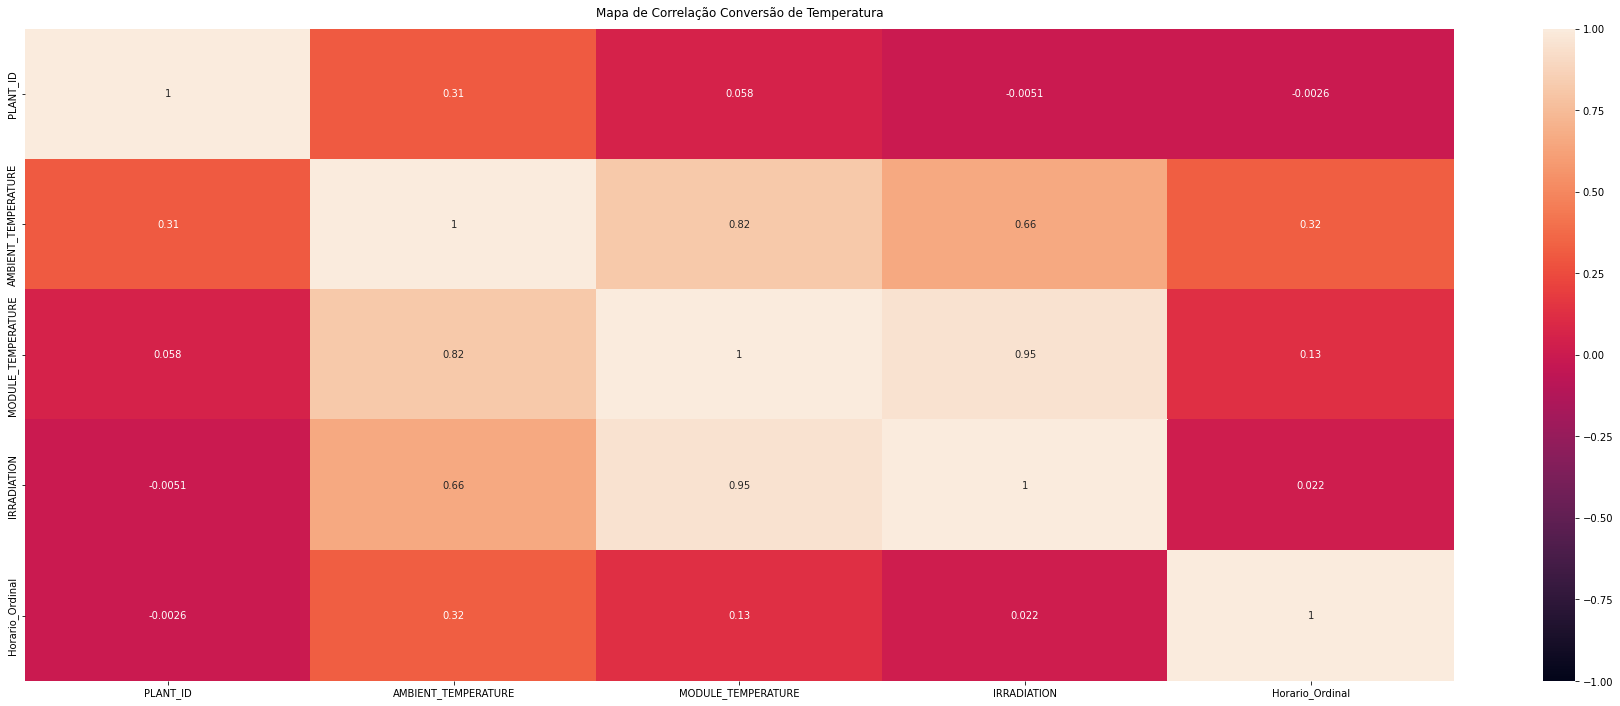

In [ ]:
#Usado para identificar a correlação entre a temperatura do inversor e a do ambiente

plt.figure(figsize=(32, 12))
heatmap3 = sns.heatmap(DF_Principal.corr(), vmin=-1, vmax=1, annot=True)
heatmap3.set_title('Mapa de Correlação Conversão de Temperatura', fontdict={'fontsize':12}, pad=12)

In [ ]:
#Modelo de Random Forest Regression, utilizado para transformar as temperaturas do ambiente em temperatura do inversor. Utiliza como input o horário ordinal e a temperatura em graus celsius. Retorna a temperatura em graus celsius

Df_Planta4135001 = DF_Principal[DF_Principal.PLANT_ID == 4135001].copy()
Df_Planta4136001 = DF_Principal[DF_Principal.PLANT_ID == 4136001].copy()

X_Treino_Planta4135001, X_Teste_Planta4135001, Y_Treino_Planta4135001, Y_Teste_Planta4135001 = train_test_split(Df_Planta4135001[['AMBIENT_TEMPERATURE','Horario_Ordinal']],Df_Planta4135001['MODULE_TEMPERATURE'],test_size=.2,random_state=42)
X_Treino_Planta4136001, X_Teste_Planta4136001, Y_Treino_Planta4136001, Y_Teste_Planta4136001 = train_test_split(Df_Planta4136001[['AMBIENT_TEMPERATURE','Horario_Ordinal']],Df_Planta4136001['MODULE_TEMPERATURE'],test_size=.2,random_state=42)
X_Treino_DuasPlantas, X_Teste_DuasPlantas, Y_Treino_DuasPlantas, Y_Teste_DuasPlantas = train_test_split(DF_Principal[['AMBIENT_TEMPERATURE','Horario_Ordinal']],DF_Principal['MODULE_TEMPERATURE'],test_size=.2,random_state=42)

#RFR significa Random Forest Regressor

RFR_Planta4135001 = RandomForestRegressor(random_state=42)
RFR_Planta4135001.fit(X_Treino_Planta4135001,Y_Treino_Planta4135001)
Y_Resultado_RFR_Planta4135001 = RFR_Planta4135001.predict(X_Teste_Planta4135001)
Acuracidade_Planta4135001 = round(r2_score(Y_Resultado_RFR_Planta4135001,Y_Teste_Planta4135001)*100, 2)

RFR_Planta4136001 = RandomForestRegressor(random_state=42)
RFR_Planta4136001.fit(X_Treino_Planta4136001,Y_Treino_Planta4136001)
Y_Resultado_RFR_Planta4136001 = RFR_Planta4136001.predict(X_Teste_Planta4136001)
Acuracidade_Planta4136001 = round(r2_score(Y_Resultado_RFR_Planta4136001,Y_Teste_Planta4136001)*100, 2)

RFR_DuasPlantas = RandomForestRegressor(random_state=42)
RFR_DuasPlantas.fit(X_Treino_DuasPlantas,Y_Treino_DuasPlantas)
Y_Resultado_RFR_DuasPlantas = RFR_DuasPlantas.predict(X_Teste_DuasPlantas)
Acuracidade_DuasPlantas = round(r2_score(Y_Resultado_RFR_DuasPlantas,Y_Teste_DuasPlantas)*100, 2)

print("Acuracidade modelo Planta 4135001: ", Acuracidade_Planta4135001,"%")
print("Acuracidade modelo Planta 4136001: ", Acuracidade_Planta4136001,"%")
print("Acuracidade modelo Geral:", Acuracidade_DuasPlantas,"%")

#Boa acuracidade nos testes, porém por se tratar de um modelo que utiliza a lógica de árvore, possui um range de valores minimos e máximos, o que se mostrou ruim para a temperatura, uma vez que os dados de treinos não possuiam temperaturas baixas, próximas ao ocorrido na utilização do mesmo.

Acuracidade modelo Planta 4135001:  100.0 %
Acuracidade modelo Planta 4136001:  100.0 %
Acuracidade modelo Geral: 100.0 %


In [ ]:
#Modelo de Regressão linear, utilizado para transformar as temperaturas do ambiente em temperatura do inversor. Utiliza como input o horário ordinal e a temperatura em graus celsius. Retorna a temperatura em graus celsius

Df_Planta4135001 = DF_Principal[DF_Principal.PLANT_ID == 4135001].copy()
Df_Planta4136001 = DF_Principal[DF_Principal.PLANT_ID == 4136001].copy()

X_Treino_Planta4135001, X_Teste_Planta4135001, Y_Treino_Planta4135001, Y_Teste_Planta4135001 = train_test_split(Df_Planta4135001[['AMBIENT_TEMPERATURE','Horario_Ordinal']],Df_Planta4135001['MODULE_TEMPERATURE'],test_size=.2,random_state=42)
X_Treino_Planta4136001, X_Teste_Planta4136001, Y_Treino_Planta4136001, Y_Teste_Planta4136001 = train_test_split(Df_Planta4136001[['AMBIENT_TEMPERATURE','Horario_Ordinal']],Df_Planta4136001['MODULE_TEMPERATURE'],test_size=.2,random_state=42)
X_Treino_DuasPlantas, X_Teste_DuasPlantas, Y_Treino_DuasPlantas, Y_Teste_DuasPlantas = train_test_split(DF_Principal[['AMBIENT_TEMPERATURE','Horario_Ordinal']],DF_Principal['MODULE_TEMPERATURE'],test_size=.2,random_state=42)

#RFC significa Random Forest Regressor

LR_Planta4135001 = linear_model.LinearRegression()
LR_Planta4135001.fit(X_Treino_Planta4135001,Y_Treino_Planta4135001)
Y_Resultado_LR_Planta4135001 = LR_Planta4135001.predict(X_Teste_Planta4135001)
Acuracidade_Planta4135001_LR = round(r2_score(Y_Resultado_LR_Planta4135001,Y_Teste_Planta4135001)*100, 2)

LR_Planta4136001 = linear_model.LinearRegression()
LR_Planta4136001.fit(X_Treino_Planta4136001,Y_Treino_Planta4136001)
Y_Resultado_LR_Planta4136001 = LR_Planta4136001.predict(X_Teste_Planta4136001)
Acuracidade_Planta4136001_LR = round(r2_score(Y_Resultado_LR_Planta4136001,Y_Teste_Planta4136001)*100, 2)

LR_DuasPlantas = linear_model.LinearRegression()
LR_DuasPlantas.fit(X_Treino_DuasPlantas,Y_Treino_DuasPlantas)
Y_Resultado_LR_DuasPlantas = LR_DuasPlantas.predict(X_Teste_DuasPlantas)
Acuracidade_DuasPlantas_LR = round(r2_score(Y_Resultado_LR_DuasPlantas,Y_Teste_DuasPlantas)*100, 2)

print("Acuracidade modelo Planta 4135001: ", Acuracidade_Planta4135001_LR,"%")
print("Acuracidade modelo Planta 4136001: ", Acuracidade_Planta4136001_LR,"%")
print("Acuracidade modelo Geral:", Acuracidade_DuasPlantas_LR,"%")

#Obteve performance ruim nos testes, portanto não foi usado

Acuracidade modelo Planta 4135001:  69.19 %
Acuracidade modelo Planta 4136001:  66.3 %
Acuracidade modelo Geral: 55.86 %


In [ ]:
#Criação de uma time series para as temperaturas do ambiente medidas

Clima['DATE_TIME'] = pd.to_datetime(Clima['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
Clima['Horario_Ordinal']=((Clima['DATE_TIME'].dt.hour*3600)+(Clima['DATE_TIME'].dt.minute*60)+(Clima['DATE_TIME'].dt.second))
Clima['Dia']=Clima['DATE_TIME'].dt.date
Clima['Hora']=Clima['DATE_TIME'].dt.hour
Clima['Minuto']=Clima['DATE_TIME'].dt.minute
Clima

Copia_Clima = Clima[Clima.Minuto == 0].copy()
Copia_Clima.sort_values(['PLANT_ID','SOURCE_KEY','DATE_TIME'],inplace=True, ignore_index=True)
Copia_Clima

Copia_Clima['Temp_Amb_1_H_Atras']=0.00
Copia_Clima['Temp_Amb_2_H_Atras']=0.00
Copia_Clima['Temp_Amb_3_H_Atras']=0.00



for linha in Copia_Clima.index:
  if Copia_Clima.at[linha,'Hora'] < 6 or Copia_Clima.at[linha,'Hora'] > 18:
    Copia_Clima.at[linha,'Temp_Amb_1_H_Atras']=0.00
    Copia_Clima.at[linha,'Temp_Amb_2_H_Atras']=0.00
    Copia_Clima.at[linha,'Temp_Amb_3_H_Atras']=0.00
  else:
    Copia_Clima.at[linha,'Temp_Amb_1_H_Atras']=Copia_Clima.at[linha-1,'AMBIENT_TEMPERATURE']
    Copia_Clima.at[linha,'Temp_Amb_2_H_Atras']=Copia_Clima.at[linha-2,'AMBIENT_TEMPERATURE']
    Copia_Clima.at[linha,'Temp_Amb_3_H_Atras']=Copia_Clima.at[linha-3,'AMBIENT_TEMPERATURE']



In [ ]:
#Treino de um modelo LR, agora incluindo no input o time series elaborado acima. Isso faz com que as temperaturas medidas nas últimas três horas do ambiente também sejam levadas em conta para a determinação da temperatura do inversor
X_Treino_DuasPlantas_TimeSeries, X_Teste_DuasPlantas_TimeSeries, Y_Treino_DuasPlantas_TimeSeries, Y_Teste_DuasPlantas_TimeSeries = train_test_split(Copia_Clima[['AMBIENT_TEMPERATURE','Horario_Ordinal','Temp_Amb_1_H_Atras','Temp_Amb_2_H_Atras','Temp_Amb_3_H_Atras']],Copia_Clima['MODULE_TEMPERATURE'],test_size=.2,random_state=42)

#RFC significa Random Forest Regressor

LR_DuasPlantas_TimeSeries = linear_model.LinearRegression()
LR_DuasPlantas_TimeSeries.fit(X_Treino_DuasPlantas_TimeSeries,Y_Treino_DuasPlantas_TimeSeries)
Y_Resultado_LR_DuasPlantas_TimeSeries = LR_DuasPlantas_TimeSeries.predict(X_Teste_DuasPlantas_TimeSeries)
Acuracidade_DuasPlantas_TimeSeries_LR = round(r2_score(Y_Resultado_LR_DuasPlantas_TimeSeries,Y_Teste_DuasPlantas_TimeSeries)*100, 2)

print("Acuracidade modelo Geral:", Acuracidade_DuasPlantas_TimeSeries_LR,"%")

# Acuracidade inferior durante os testes, porém se mostrou melhor que o RFR quando as temperaturas são mais baixas que as presentes na elaboração do modelo

Acuracidade modelo Geral: 81.13 %


In [ ]:
#Treino de um modelo RFR, agora incluindo no input o time series elaborado acima. Isso faz com que as temperaturas medidas nas últimas três horas do ambiente também sejam levadas em conta para a determinação da temperatura do inversor
X_Treino_DuasPlantas_TimeSeries, X_Teste_DuasPlantas_TimeSeries, Y_Treino_DuasPlantas_TimeSeries, Y_Teste_DuasPlantas_TimeSeries = train_test_split(Copia_Clima[['AMBIENT_TEMPERATURE','Horario_Ordinal','Temp_Amb_1_H_Atras','Temp_Amb_2_H_Atras','Temp_Amb_3_H_Atras']],Copia_Clima['MODULE_TEMPERATURE'],test_size=.2,random_state=42)

#RFC significa Random Forest Regressor

RFR_DuasPlantas_TimeSeries = RandomForestRegressor(random_state=42)
RFR_DuasPlantas_TimeSeries.fit(X_Treino_DuasPlantas_TimeSeries,Y_Treino_DuasPlantas_TimeSeries)
Y_Resultado_RFR_DuasPlantas_TimeSeries = RFR_DuasPlantas_TimeSeries.predict(X_Teste_DuasPlantas_TimeSeries)
Acuracidade_DuasPlantas_TimeSeries_RFR = round(r2_score(Y_Resultado_RFR_DuasPlantas_TimeSeries,Y_Teste_DuasPlantas_TimeSeries)*100, 2)

print("Acuracidade modelo Geral:", Acuracidade_DuasPlantas_TimeSeries_RFR,"%")


#Acuracidade superior nos testes, porém os dados usados para criação do modelo possuem temperaturas minimas maiores que os testes em produção realizados.
#Por se tratar em um modelo baseado em uma estrutura de árvores, o modelo acaba tendo outputs de temperatura minima maiores do que as temperaturas medidas, assim inserindo um delta grande em alguns casos de dias mais frios, principalmente nas primeiras 6h.
#Portanto não foi utilizado

Acuracidade modelo Geral: 93.73 %


In [ ]:
with open('Modelo_TempAmb_para_TempInversor','wb') as f:
  pickle.dump(LR_DuasPlantas_TimeSeries,f)

with open('Modelo_TempInversor_para_GeracaoEnergia','wb') as f:
  pickle.dump(RFR_Geral_Dia,f)